# Let's divide users in gropus of interactions

In [1]:
from Utils.Toolkit import TestGen, TestSplit, DataReader, get_data
import numpy as np

data = get_data()
URM_all = data['URM_all'].tocsr()
target_users = data['target_users']

URM_train = data['train'].tocsr()
URM_test = data['test'].tocsr()

In [2]:
profile_length = np.ediff1d(URM_train.indptr)
profile_length[:10]

array([ 6,  5,  9,  0,  7, 35,  4,  3,  2, 13], dtype=int32)

In [3]:
block_size = int(len(profile_length)*0.15)
block_size

4636

In [4]:
sorted_users = np.argsort(profile_length)
sorted_users.shape

(30911,)

In [5]:
for group_id in range(0, 7):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))

Group 0, average p.len 0.00, min 0, max 0
Group 1, average p.len 0.79, min 0, max 2
Group 2, average p.len 3.39, min 2, max 5
Group 3, average p.len 6.81, min 5, max 9
Group 4, average p.len 12.16, min 9, max 16
Group 5, average p.len 22.10, min 16, max 31
Group 6, average p.len 52.21, min 31, max 676


In [6]:
from CF.item_cf import ItemBasedCollaborativeFiltering
from CF.user_cf import UserBasedCollaborativeFiltering

itemCF = ItemBasedCollaborativeFiltering(topK=29, shrink=5)
itemCF.fit(URM_train.copy())
userCF = UserBasedCollaborativeFiltering(topK=102, shrink=7)
userCF.fit(URM_train.copy())

In [7]:
from SLIM.SLIM_BPR_Cython import SLIM_BPR_Cython
from Algorithms.Base.Evaluation.Evaluator import EvaluatorHoldout
from Algorithms.Notebooks_utils.data_splitter import train_test_holdout


bayesian_args = {'topK': 547, 'epochs': 120, 'symmetric': True, 'sgd_mode': 'adagrad', 'lambda_i': 2.9288627980909483e-05, 'lambda_j': 0.0008452530534290479, 'learning_rate': 0.000730447099956657}
args = bayesian_args

recommender = SLIM_BPR_Cython(epochs=args['epochs'],
                              topK=args['topK'],
                              lambda_i=args['lambda_i'],
                              lambda_j=args['lambda_j'],
                              positive_threshold=1,
                              sgd_mode=args['sgd_mode'],
                              symmetric=args['symmetric'],
                              learning_rate=args['learning_rate']
                              )

%time recommender.fit(URM_train.copy())

100%|██████████| 28106/28106 [00:25<00:00, 1107.51it/s]


0.022078684169040373
CPU times: user 16.9 s, sys: 797 ms, total: 17.7 s
Wall time: 15.9 s


In [8]:
from NonPersonalized.top_pop import TopPop

topPop = TopPop()
topPop.fit(URM_train.copy())

In [11]:
from HYB.hybrid import HybridRecommender
from Utils.Toolkit import get_data

userCF_args = {
    'topK' : 102,
    'shrink' : 7
}

itemCF_args = {
    'topK' : 29,
    'shrink' : 5
}

SLIM_BPR_args = {
    'topK': 20,
    'lambda_i': 5.0,
    'lambda_j': 7.0,
    'epochs': 5000,
    'learning_rate' : 1e-4,
    'sgd_mode' : 'adam'
}

weights = {
    'user_cf' : 0,
    'item_cf' : 1,
    'SLIM_BPR' : 0,
    'item_cbf' : 0
}

hyb = HybridRecommender(weights=weights, userCF_args=userCF_args, itemCF_args=itemCF_args, SLIM_BPR_args=SLIM_BPR_args)
%time hyb.fit(URM_train.copy(), data['ICM_asset'].tocsr(), data['ICM_subclass'].tocsr())

{'user_cf': 0, 'item_cf': 1, 'SLIM_BPR': 0, 'item_cbf': 0}
{'topK': 102, 'shrink': 7}
{'topK': 29, 'shrink': 5}
{'topK': 20, 'lambda_i': 5.0, 'lambda_j': 7.0, 'epochs': 5000, 'learning_rate': 0.0001, 'sgd_mode': 'adam'}
CPU times: user 38.4 s, sys: 686 ms, total: 39.1 s
Wall time: 36.8 s


# Evaluate for different user groups

In [12]:
from Algorithms.Notebooks_utils.evaluation_function import evaluate_MAP_target_users

MAP_itemCF = []
MAP_userCF = []
MAP_SLIM = []
MAP_topPop = []
MAP_hyb = []

for group_id in range(0, 7):
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluate_map = evaluate_MAP_target_users(URM_test, itemCF, users_in_group, verbose=False)
    MAP_itemCF.append(evaluate_map)
    evaluate_map = evaluate_MAP_target_users(URM_test, userCF, users_in_group, verbose=False)
    MAP_userCF.append(evaluate_map)
    evaluate_map = evaluate_MAP_target_users(URM_test, recommender, users_in_group, verbose=False)
    MAP_SLIM.append(evaluate_map)
    evaluate_map = evaluate_MAP_target_users(URM_test, topPop, users_in_group, verbose=False)
    MAP_topPop.append(evaluate_map)
    evaluate_map = evaluate_MAP_target_users(URM_test, hyb, users_in_group, verbose=False)
    MAP_hyb.append(evaluate_map)

  8%|▊         | 364/4636 [00:00<00:01, 3615.27it/s]

Group 0, average p.len 0.00, min 0, max 0


  7%|▋         | 316/4636 [00:00<00:01, 3149.01it/s]

Group 1, average p.len 0.79, min 0, max 2


  3%|▎         | 138/4636 [00:00<00:03, 1377.18it/s]

Group 2, average p.len 3.39, min 2, max 5


  3%|▎         | 133/4636 [00:00<00:03, 1320.68it/s]

Group 3, average p.len 6.81, min 5, max 9


  2%|▏         | 114/4636 [00:00<00:03, 1134.01it/s]

Group 4, average p.len 12.16, min 9, max 16


  2%|▏         | 105/4636 [00:00<00:04, 1045.64it/s]

Group 5, average p.len 22.10, min 16, max 31


  3%|▎         | 95/3095 [00:00<00:03, 942.16it/s]

Group 6, average p.len 52.21, min 31, max 676


100%|██████████| 3095/3095 [00:05<00:00, 565.21it/s]


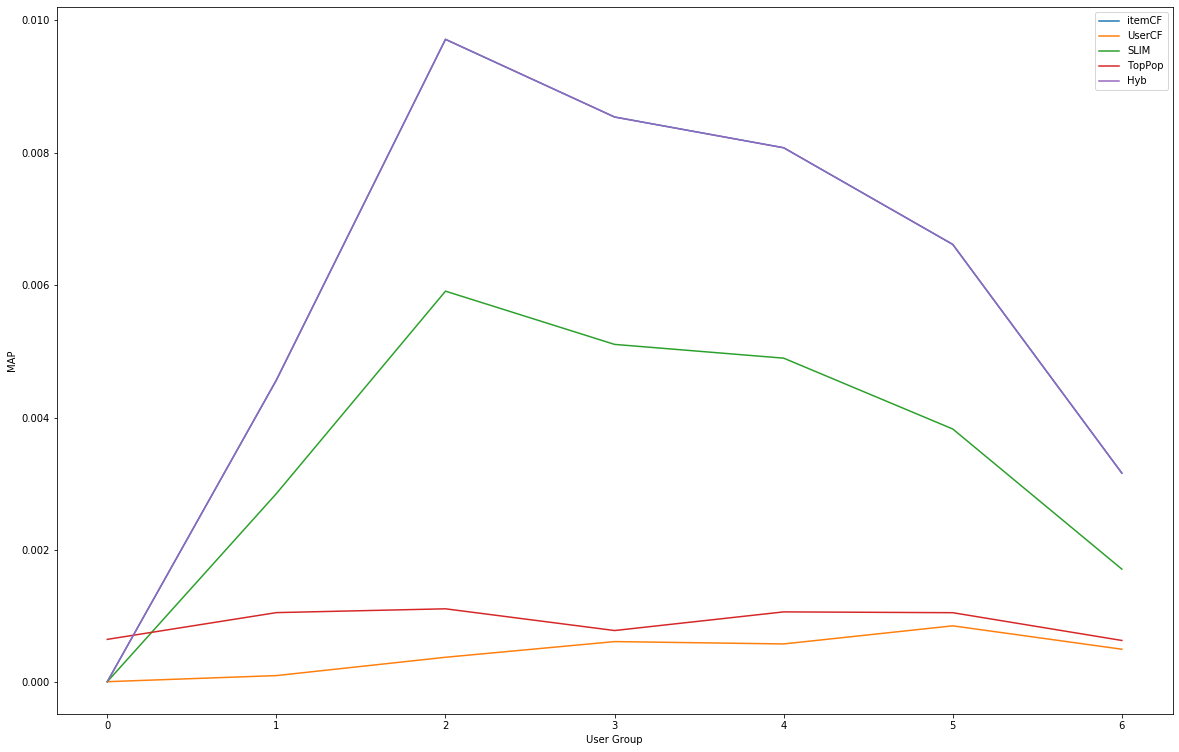

In [13]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.figure(figsize=(20,13))
pyplot.plot(MAP_itemCF, label="itemCF")
pyplot.plot(MAP_userCF, label="UserCF")
pyplot.plot(MAP_SLIM, label="SLIM")
pyplot.plot(MAP_topPop, label="TopPop")
pyplot.plot(MAP_hyb, label="Hyb")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()

In [14]:
score = itemCF.get_expected_recommendations(4000)
score.astype(float)
score

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
rank = score.argsort()[::-1]
rank[:10]

array([ 192,  197, 5192, 5133,  194, 6793, 9302, 5189,  187, 4785])

In [16]:
MAP_hyb

[1.051405648474653e-05,
 0.004568158558647381,
 0.00971380712573168,
 0.008538299665244761,
 0.008074512951417602,
 0.006615921901742475,
 0.003160353354459012]

In [17]:
MAP_itemCF

[1.051405648474653e-05,
 0.004564923464344381,
 0.009711239590570573,
 0.008539686134231759,
 0.008074962270070797,
 0.006614304354590976,
 0.003160353354459012]

In [18]:
np.isin(hyb.recommend(41), itemCF.recommend(41))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [19]:
type(URM_train.copy())

scipy.sparse.csr.csr_matrix